## Load the Haystack pipeline from Amazon S3 and run inferences - Part 2
---

In this notebook, we will we load the haystack pipeline that is stored in S3 as a `yml` file. Once the haystack pipeline is loaded, we will run a series of questions against the pipeline and measure different metrics, such as latency, accuracy metrics, etc. 

In [19]:
# import libraries
import os
import dspy
import json
import boto3
import pickle
import logging
import tempfile
import pandas as pd
import globals as g
from typing import List
from haystack import Pipeline
from haystack.components.evaluators import SASEvaluator, AnswerExactMatchEvaluator

In [20]:
# Set a logger
logging.basicConfig(format='[%(asctime)s] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

Now, we will load the pipeline from the s3 bucket where it was saved as a `yml` file, and then see the contents of the pipeline. We will then run a series of inference requests against the pipeline and measure latency and accuracy metrics

In [21]:
# Initialize the S3 client
s3_client = boto3.client('s3')

# Create temporary file and download pipeline
with tempfile.NamedTemporaryFile(mode='wb', suffix='.yml', delete=False) as tmp_file:
    # Download from the same location where we uploaded
    s3_client.download_fileobj(
        g.HAYSTACK_PIPELINE_BUCKET, 
        g.HAYSTACK_PIPELINE_KEY, 
        tmp_file
    )
    logger.info(f"Downloaded the haystack pipeline from {g.HAYSTACK_PIPELINE_BUCKET}/{g.HAYSTACK_PIPELINE_KEY} to {tmp_file.name}")
    tmp_file_path = tmp_file.name

In [22]:
# Download and load document store
doc_store_key = "pipelines/document_store/haystack_docstore.pkl"
with tempfile.NamedTemporaryFile(mode='wb', suffix='.pkl', delete=False) as tmp_file:
    s3_client.download_fileobj(
        g.HAYSTACK_PIPELINE_BUCKET, 
        doc_store_key, 
        tmp_file
    )
    print(f"Downloaded the document store from {g.HAYSTACK_PIPELINE_BUCKET}/{doc_store_key} to {tmp_file.name}")
    docstore_tmp_path = tmp_file.name

Downloaded the document store from sagemaker-us-east-2-015469603702/pipelines/document_store/haystack_docstore.pkl to /var/folders/jy/g9mb5j5n6c11fgdj788p5rww0000gr/T/tmpdfyncxe4.pkl


In [23]:
# Now we will load the pipeline from the temporary file path
with open(tmp_file_path, 'r') as file:
    loaded_pipeline = Pipeline.load(file)
    print(f"Loaded the haystack pipeline from {tmp_file_path}")

# Load the document store
with open(docstore_tmp_path, 'rb') as file:
    loaded_document_store = pickle.load(file)
    print(f"Loaded the document store from pickle file: {docstore_tmp_path}")

Loaded the haystack pipeline from /var/folders/jy/g9mb5j5n6c11fgdj788p5rww0000gr/T/tmpl0fv17md.yml
Loaded the document store from pickle file: /var/folders/jy/g9mb5j5n6c11fgdj788p5rww0000gr/T/tmpdfyncxe4.pkl


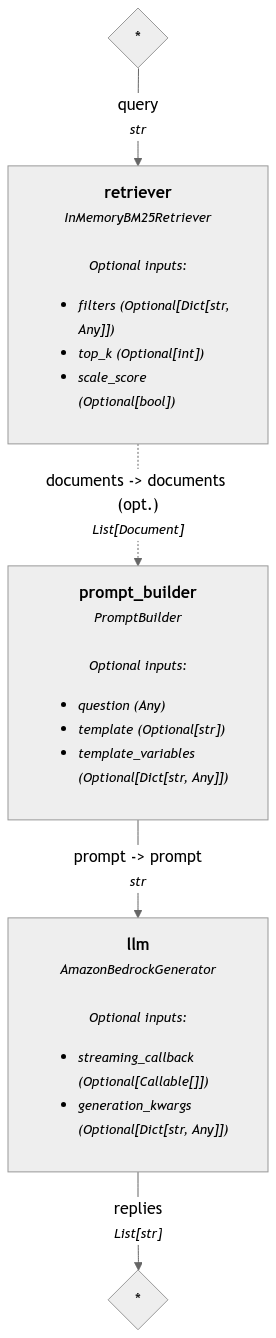

In [24]:
# Now we will clean up the temporary file path and then see the contents of the pipeline
# that we had saved to s3
os.remove(tmp_file_path)
logger.info("Loaded Pipeline Structure:")
loaded_pipeline.show()

### Run inferences against the haystack pipeline using Amazon Bedrock
---

Now that we have loaded the pipeline from `s3`, we can run some inferences against this RAG pipeline. As we run inferences, we will measure latency and semantic similarity using the `SASEvaluator` module from haystack.

In [26]:
# Load the dataset that we processed in the first notebook
df = pd.read_csv(os.path.join(g.DATA_DIR, g.PUBMED_QA_CSV_FNAME)) 

# We will select the first 10 rows of the dataset for testing
test_data = df.head(20)
test_data

,instruction,context,response,category
0,Do cC and CXC chemokine levels in children wit...,Chemokines are a superfamily of small peptides...,Initial-phase serum levels of chemokines in pa...,closed_qa
1,Are sAH gene variants associated with obesity-...,The SAH gene locus has recently been proposed ...,We confirm recent evidence that the SAH locus ...,closed_qa
2,Do the functional anatomy of gaze-evoked tinni...,To identify neural sites associated with gaze-...,Patients with GET have plastic changes in mult...,closed_qa
3,Does neighborhood fast-food outlet exposure am...,Greater exposures to fast-food outlets and low...,These findings suggest that efforts to improve...,closed_qa
4,Does conditioned pain modulation predict exerc...,Conditioned pain modulation (CPM) is the conce...,"CPM was attenuated in older adults, as measure...",closed_qa
5,Does notch-1 promote breast cancer cells proli...,Notch signaling is indicated as novel therapeu...,Notch-1 promotes breast cancer cells prolifera...,closed_qa
6,Chronic osteomyelitis in childhood: is surgery...,"Presently, most children with chronic osteomye...",Our diagnostic procedure was useful to reduce ...,closed_qa
7,Does exercise protect against articular cartil...,It has been reported that osteoarthritis can o...,A sedentary lifestyle in the hamster leads to ...,closed_qa
8,Does bisoprolol/amlodipine combination therapy...,The efficacy of a bisoprolol/amlodipine fixed-...,Bisoprolol/amlodipine FDC therapy is associate...,closed_qa
9,Does global DNA hypomethylation occur in the e...,Global DNA hypomethylation has been found in t...,Global DNA hypomethylation occurs in the early...,closed_qa


In [33]:
question: str = "What is a neurodegenerative disease? Give me examples"
document_store = loaded_pipeline.get_component('retriever')
# Directly query the document store to simulate what the BM25 retriever would retrieve
retrieved_docs = document_store.run(question)  # Use the question as the query

# Print the retrieved documents' content or metadata
print(f"Retrieved Documents: {retrieved_docs}")

# Now proceed with the full pipeline run to generate the final response
response = loaded_pipeline.run({
    "retriever": {"query": question},
    "prompt_builder": {"question": question}
})
print("LLM Response:")
print(response["llm"]["replies"][0])


Retrieved Documents: {'documents': []}
LLM Response:
Here is a concise answer to the question:

A neurodegenerative disease is a condition in which nerve cells in the brain and nervous system progressively lose function and die. Examples of neurodegenerative diseases include:

- Alzheimer's disease - causes progressive memory loss and cognitive decline
- Parkinson's disease - leads to tremors, muscle stiffness, and loss of motor control
- Huntington's disease - causes uncontrolled movements


In [ ]:
# Update the pipeline's retriever with the loaded document store
retriever = loaded_pipeline.get_component("retriever")
retriever.document_store = loaded_document_store

# Verify documents are loaded
doc_count = len(loaded_document_store.filter_documents())
print(f"Number of documents in loaded store: {doc_count}")

Number of documents in loaded store: 0


In [ ]:
# Update the pipeline's retriever with the loaded document store
retriever = loaded_pipeline.get_component("retriever")
retriever.document_store = loaded_document_store

# Verify documents are loaded
doc_count = len(loaded_document_store.filter_documents())
print(f"Number of documents in loaded store: {doc_count}")

Number of documents in loaded store: 0


### Measure the `SASEvaluation` score

Now, we will use Haystack's `SAS evaluator` to generate answers to the first 20 questions of the dataset. `SASEvaluator` will evaluate the answer predicted my the pipeline that we have loaded and then compare the semantic similarity to the ground truth provided in the dataset.

In [14]:
# Initiatize and warm up the SAS evaluator
sas_evaluator = SASEvaluator()
sas_evaluator.warm_up()

2024-11-14T18:26:20.530178Z [info     ] Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-mpnet-base-v2 lineno=218 module=sentence_transformers.SentenceTransformer
[2024-11-14 13:26:20,530] p43780 {SentenceTransformer.py:218} INFO - Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-mpnet-base-v2


In [16]:
results: List = []
questions = test_data['instruction'].tolist()
ground_truth_answers = test_data['response'].tolist()
logger.info(f"Ready to start generating inferences to the instructions provided:")

2024-11-14T18:27:05.684788Z [info     ] Ready to start generating inferences to the instructions provided: lineno=4 module=__main__
[2024-11-14 13:27:05,684] p43780 {507374900.py:4} INFO - Ready to start generating inferences to the instructions provided:


In [17]:
logger.info("Running inferences...")
for question in questions:
    try:
        response = loaded_pipeline.run({
            "retriever": {"query": question}, 
            "prompt_builder": {"question": question}
        })
        predicted_answer = response["llm"]["replies"][0]
        results.append(predicted_answer)
        
        # Print each question and response
        logger.info("\nQuestion:", question)
        logger.info("Predicted Answer:", predicted_answer)
        logger.info("Ground Truth:", ground_truth_answers[questions.index(question)])
        logger.info("-" * 80)
        
    except Exception as e:
        logger.info(f"Error processing question: {question}: {e}")
        results = None

2024-11-14T18:27:56.823739Z [info     ] Running inferences...          lineno=1 module=__main__
[2024-11-14 13:27:56,823] p43780 {2117199774.py:1} INFO - Running inferences...
2024-11-14T18:27:56.837318Z [info     ] Running component retriever    component_name=retriever lineno=66 module=haystack.core.pipeline.pipeline
[2024-11-14 13:27:56,837] p43780 {pipeline.py:66} INFO - Running component retriever
2024-11-14T18:27:56.844806Z [info     ] No documents found for BM25 retrieval. Returning empty list. lineno=518 module=haystack.document_stores.in_memory.document_store
[2024-11-14 13:27:56,844] p43780 {document_store.py:518} INFO - No documents found for BM25 retrieval. Returning empty list.
2024-11-14T18:27:56.848974Z [info     ] Running component prompt_builder component_name=prompt_builder lineno=66 module=haystack.core.pipeline.pipeline
[2024-11-14 13:27:56,848] p43780 {pipeline.py:66} INFO - Running component prompt_builder
2024-11-14T18:27:56.851711Z [info     ] Running component 

KeyboardInterrupt: 

In [ ]:
# Evaluate results
print("\nCalculating evaluation metrics...")
em_evaluation = em_evaluator.run(
    ground_truth_answers=ground_truth_answers,
    predicted_answers=results
)

sas_evaluation = sas_evaluator.run(
    ground_truth_answers=ground_truth_answers,
    predicted_answers=results
)

# Print evaluation results
print("\nEvaluation Results:")
print("-" * 40)
print("Exact Match Evaluation:")
print(f"Overall score: {em_evaluation['score']:.4f}")
print("\nSemantic Answer Similarity Evaluation:")
print(f"Overall score: {sas_evaluation['score']:.4f}")

# Print detailed results for each question
print("\nDetailed Results:")
print("-" * 80)
for i, (question, ground_truth, predicted) in enumerate(zip(questions, ground_truth_answers, results)):
    print(f"\nQuestion {i+1}: {question[:100]}...")  # Show first 100 chars of question
    print(f"Ground Truth: {ground_truth[:100]}...")  # Show first 100 chars of ground truth
    print(f"Predicted: {predicted[:100]}...")        # Show first 100 chars of prediction
    print(f"Exact Match Score: {em_evaluation['individual_scores'][i]:.4f}")
    print(f"SAS Score: {sas_evaluation['individual_scores'][i]:.4f}")
    print("-" * 80)

# Calculate and print additional statistics
import numpy as np

sas_scores = sas_evaluation['individual_scores']
print("\nStatistical Analysis:")
print(f"Mean SAS Score: {np.mean(sas_scores):.4f}")
print(f"Median SAS Score: {np.median(sas_scores):.4f}")
print(f"Standard Deviation: {np.std(sas_scores):.4f}")
print(f"Min Score: {np.min(sas_scores):.4f}")
print(f"Max Score: {np.max(sas_scores):.4f}")